# Initials

In [2]:
!dir /b /a-d data

test.jsonl
train.jsonl
validate.jsonl


# Imports

In [3]:
import os
import os.path as osp

import json
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize

In [5]:
# function to read the data file

def read_jsonl(path):
    data = []
    
    with open(path, 'r', encoding='utf-8') as fd:
        for line in fd:
            line_data = json.loads(line)
            data.append(line_data)
            
    return data


# Read data

In [6]:
data_fol  = "data"

train_path = osp.join(data_fol, "train.jsonl")
val_path = osp.join(data_fol, "validate.jsonl")
test_path = osp.join(data_fol, "test.jsonl")

In [7]:
train_data = read_jsonl(train_path)
val_data = read_jsonl(val_path)
test_data = read_jsonl(test_path)

In [8]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [9]:
train_df.shape, val_df.shape, test_df.shape

((2735, 3), (341, 3), (343, 3))

# View Dataframe

In [10]:
train_df.head()

,idx,inputs,target
0,0,"The lungs are clear, and without focal air spa...",No acute cardiopulmonary abnormality.
1,1,Cardiomediastinal silhouette is within normal ...,1. No acute cardiopulmonary abnormality.
2,2,Heart size and pulmonary vascularity appears n...,No evidence of active disease.
3,3,Cardiac and mediastinal silhouette are unremar...,No acute cardiopulmonary abnormality.
4,4,The heart size and cardiomediastinal silhouett...,No acute cardiopulmonary findings.


In [11]:
for x in train_data[:5]:
    print(x)
    print("_"*100)

{'idx': 0, 'inputs': 'The lungs are clear, and without focal air space opacity. The cardiomediastinal silhouette is normal in size and contour, and stable. There is no pneumothorax or large pleural effusion.', 'target': 'No acute cardiopulmonary abnormality.'}
____________________________________________________________________________________________________
{'idx': 1, 'inputs': 'Cardiomediastinal silhouette is within normal limits of size and appearance. Pulmonary vascularity is unremarkable. Morgagni hernia, stable. Lungs are expanded and clear of air space disease or consolidation. Negative for pneumothorax or pleural effusion. Limited evaluation reveals diffuse demineralization with stable anterior wedging at the lower thoracic levels.', 'target': '1. No acute cardiopulmonary abnormality.'}
____________________________________________________________________________________________________
{'idx': 2, 'inputs': 'Heart size and pulmonary vascularity appears normal limits. Lungs are 

In [12]:
train_df.tail()

,idx,inputs,target
2730,2730,The heart is normal in size and contour. The l...,No acute cardiopulmonary disease.
2731,2731,"The lungs are clear, and without focal airspac...",No acute cardiopulmonary abnormality.
2732,2732,2 images. Heart size and pulmonary vascular en...,No acute cardiopulmonary abnormality identified.
2733,2733,Cardiomediastinal silhouette is within normal ...,No acute cardiopulmonary findings. .
2734,2734,Low lung volumes. XXXX normal heart size. No p...,"Low lung volumes, no acute cardiopulmonary dis..."


In [13]:
val_df.tail()

,idx,inputs,target
336,3071,Heart size and mediastinal contour within norm...,"No acute cardiopulmonary abnormality, specific..."
337,3072,Heart size is upper limits of normal but stabl...,1. No acute radiographic cardiopulmonary process.
338,3073,The heart size and mediastinal contours appear...,No acute cardiopulmonary findings.
339,3074,The cardiac contours are normal. Prior granulo...,No acute process.
340,3075,There is a rounded dense opacity in the latera...,Opacity XXXX representing left upper lobe pneu...


In [14]:
test_df.tail()

,idx,inputs,target
338,3414,Severe emphysematous disease is again noted. M...,Stable findings consistent with severe emphyse...
339,3415,The heart is normal size. The mediastinum is u...,No acute cardiopulmonary abnormality.
340,3416,The cardiomediastinal silhouette is normal in ...,"Low lung volumes, otherwise clear."
341,3417,The heart size is enlarged. Tortuous aorta. Ot...,1. Cardiomegaly without lung infiltrates.
342,3418,The cardiomediastinal silhouette is within nor...,1. No acute radiographic cardiopulmonary process.


# Analysis

## sentence length

In [15]:
# measure input text length in terms of no of words
train_sen_len = train_df['inputs'].str.split().apply(len)
train_sen_len.min(), train_sen_len.max()

(1, 169)

In [16]:
# measure input text length in terms of no of characters
train_sen_ch_len = train_df['inputs'].apply(len)
train_sen_ch_len.min(), train_sen_ch_len.max()

(6, 1054)

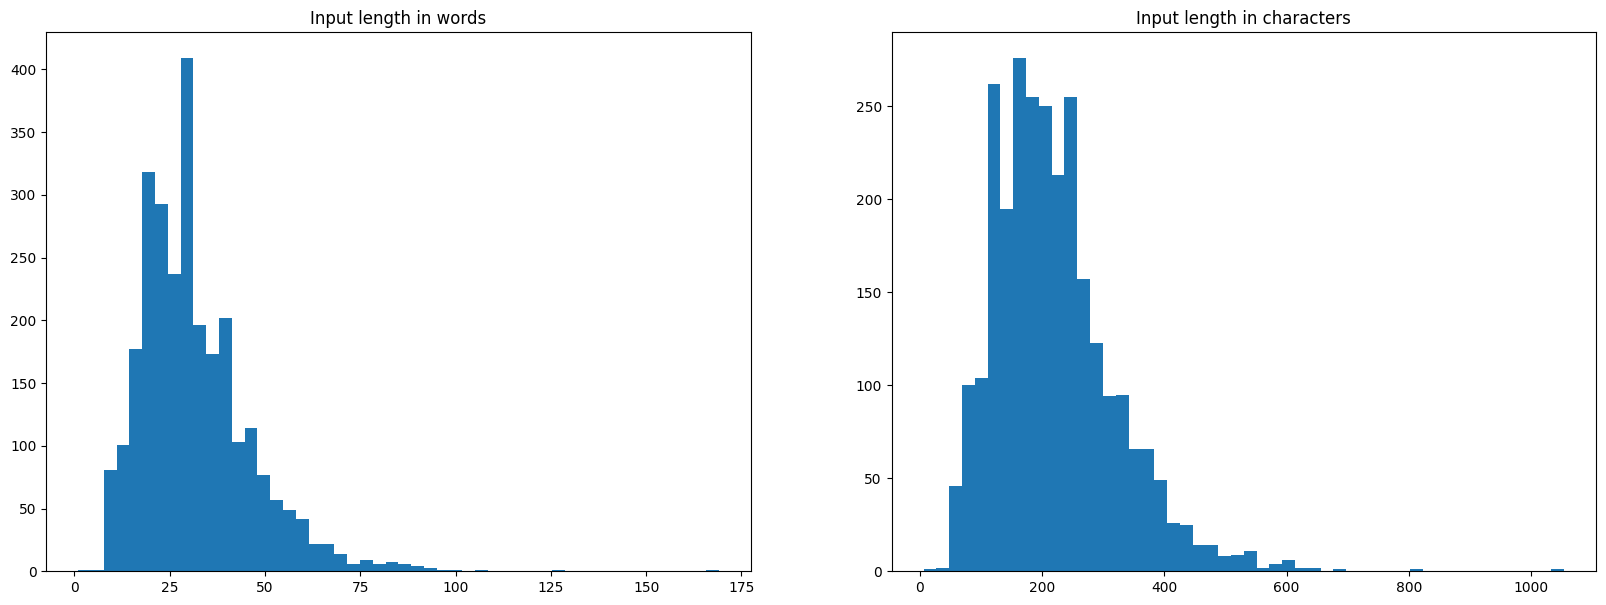

In [17]:
# plot the histograms for input text

_, ax = plt.subplots(1,2, figsize=(20, 7))
ax = ax.ravel()

ax[0].set_title("Input length in words")
ax[0].hist(train_sen_len, bins=50)

ax[1].set_title("Input length in characters")
ax[1].hist(train_sen_ch_len, bins=50)

plt.show()

In [18]:
# measure target text length in terms of no of words
train_tar_len = train_df['target'].str.split().apply(len)
train_tar_len.min(), train_tar_len.max()

(1, 119)

In [19]:
# measure target text length in terms of no of characters
train_tar_ch_len = train_df['target'].apply(len)
train_tar_ch_len.min(), train_tar_ch_len.max()

(5, 837)

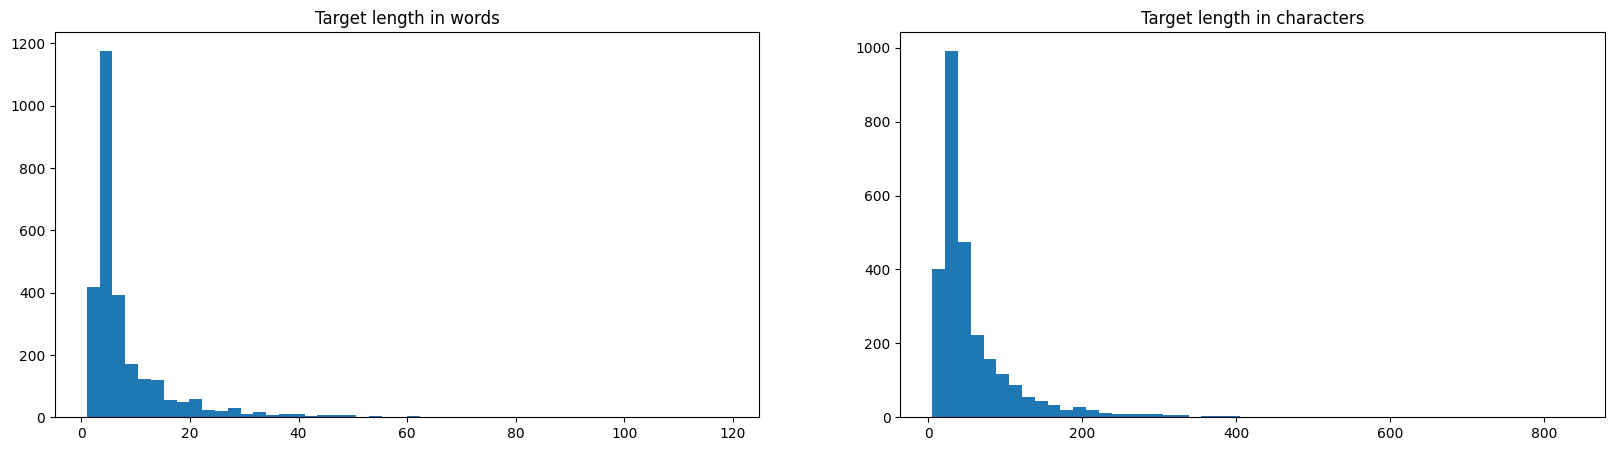

In [20]:
# plot the histograms for target text

_, ax = plt.subplots(1,2, figsize=(20, 5))
ax = ax.ravel()

ax[0].set_title("Target length in words")
ax[0].hist(train_tar_len, bins=50)

ax[1].set_title("Target length in characters")
ax[1].hist(train_tar_ch_len, bins=50)

plt.show()

## word frequency

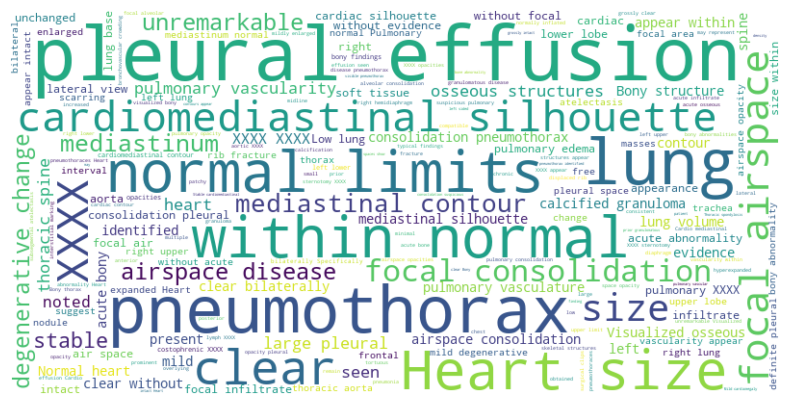

In [21]:
# Train input text wordcloud

wcinp = " ".join(train_df['inputs'])
wci = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(wcinp)

plt.figure(figsize=(10, 5))
plt.imshow(wci, interpolation="bilinear")
# plt.title("Input Text Wordcloud")
plt.axis("off")
plt.show()

In [22]:
# get single list of all words in the text

sentence_list_inputs = train_df['inputs'].tolist()
sentence_list_inputs = [ word for x in sentence_list_inputs for word in word_tokenize(x)  ]

In [23]:
"Total no of words in input text: " + str(len(sentence_list_inputs))

'Total no of words in input text: 101520'

In [24]:
freq_map = Counter(sentence_list_inputs)
len(freq_map)

1991

In [25]:
# top most common 20 words in input text data
freq_map.most_common(20)

[('.', 12551),
 ('is', 3550),
 ('are', 3491),
 ('The', 2842),
 ('normal', 2520),
 (',', 2455),
 ('No', 2292),
 ('the', 2280),
 ('and', 2253),
 ('pleural', 1968),
 ('of', 1959),
 ('XXXX', 1942),
 ('or', 1922),
 ('pneumothorax', 1921),
 ('There', 1909),
 ('effusion', 1791),
 ('size', 1544),
 ('focal', 1378),
 ('within', 1215),
 ('lungs', 1207)]

In [26]:
# top most common next 20 words in input text data
freq_map.most_common(40)[20:]

[('no', 1207),
 ('clear', 1189),
 ('limits', 1175),
 ('in', 1161),
 ('heart', 904),
 ('consolidation', 842),
 ('Heart', 836),
 ('pulmonary', 792),
 ('silhouette', 782),
 ('right', 667),
 ('airspace', 655),
 ('mediastinal', 584),
 ('left', 582),
 ('acute', 541),
 ('lung', 506),
 ('with', 504),
 ('spine', 493),
 ('disease', 486),
 ('cardiomediastinal', 476),
 ('changes', 476)]

In [27]:
# rare 20 words in input text data
least_common = sorted(freq_map.items(), key=lambda x: x[1])
least_common[:20]

[('Morgagni', 1),
 ('Callus', 1),
 ('exclusion', 1),
 ('Included', 1),
 ('clavicular', 1),
 ('representative', 1),
 ('Age-indeterminate', 1),
 ('Radiographic', 1),
 ('detail', 1),
 ('Two-view', 1),
 ('foot', 1),
 ('Hindfoot', 1),
 ('midfoot', 1),
 ('forefoot', 1),
 ('innominate', 1),
 ('2.0', 1),
 ('posterobasal', 1),
 ('benefit', 1),
 ('followup', 1),
 ('implanted', 1)]

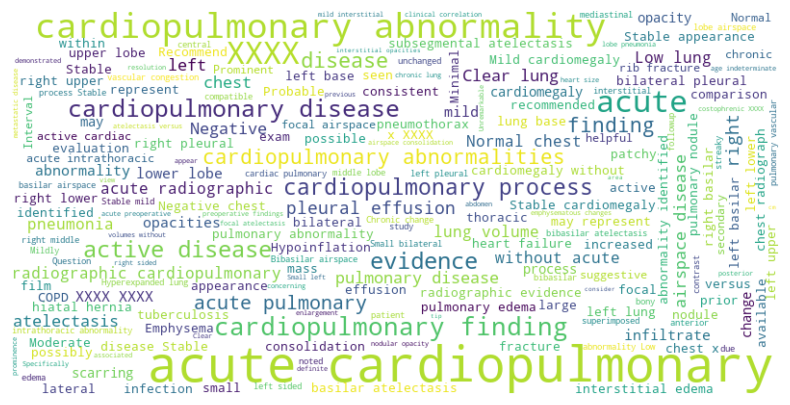

In [28]:
# Train target wordcloud

wcinp = " ".join(train_df['target'])
wci = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(wcinp)

plt.figure(figsize=(10, 5))
plt.imshow(wci, interpolation="bilinear")
# plt.title("Input Text Wordcloud")
plt.axis("off")
plt.show()

In [29]:
# single list for all words in the target text data
sentence_list_targets = train_df['target'].tolist()
sentence_list_targets = [ word for x in sentence_list_targets for word in word_tokenize(x)  ]

In [30]:
"Total no of words in input text: " + str(len(sentence_list_targets))

'Total no of words in input text: 27760'

In [31]:
freq_map = Counter(sentence_list_targets)
len(freq_map)

1461

In [32]:
# target text top 20 words
freq_map.most_common(20)

[('.', 4812),
 ('No', 1904),
 ('acute', 1778),
 ('cardiopulmonary', 1219),
 ('disease', 775),
 ('1', 637),
 ('abnormality', 621),
 ('of', 540),
 ('XXXX', 514),
 (',', 458),
 ('the', 363),
 ('findings', 322),
 ('2', 307),
 ('with', 298),
 ('pulmonary', 289),
 ('active', 259),
 ('process', 249),
 ('evidence', 229),
 ('and', 223),
 ('chest', 219)]

In [33]:
# target text rare 20 words
least_common = sorted(freq_map.items(), key=lambda x: x[1])
least_common[:20]

[('multilobar', 1),
 ('Without', 1),
 ('comparisons', 1),
 ('exposure', 1),
 ('suspicion', 1),
 ('resolve', 1),
 ('innominate', 1),
 ('noncalcified', 1),
 ('failure/pulmonary', 1),
 ('Retrolisthesis', 1),
 ('two', 1),
 ('contours', 1),
 ('reduction', 1),
 ('processes', 1),
 ('Aortic', 1),
 ('ectasia', 1),
 ('paraesophageal', 1),
 ('intrapulmonary', 1),
 ('hiatus', 1),
 ('3.Chronic', 1)]

## Other analysis

<b>Summarization ratio</b>

In [34]:
# get the ratio of input text length to summary text length

ratio_ll = train_df["inputs"].apply(len) / train_df["target"].apply(len)
ratio_ll = ratio_ll.sort_values(ascending=True)
ratio_ll

1726     0.016438
2232     0.167513
1068     0.410526
1407     0.458781
1123     0.522523
          ...    
343     23.235294
2626    25.388889
1909    28.200000
147     33.000000
486     33.800000
Length: 2735, dtype: float64

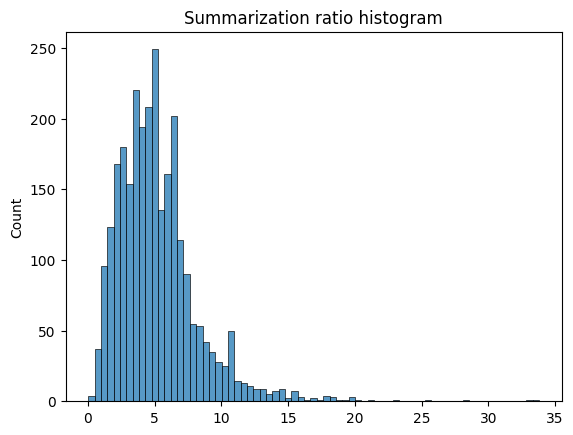

In [35]:
# histogram for the summarization ratio

sns.histplot(ratio_ll)
plt.title("Summarization ratio histogram")
plt.show()

In [36]:
ratio_ll_th = ratio_ll[ratio_ll<1]
print("There are total ", ratio_ll_th.shape[0], "rows where summary length extends the document/article length.")

There are total  45 rows where summary length extends the document/article length.


<b>Words overlapping analysis between inputs and target text</b>

In [37]:
input_unique_words = set(sentence_list_inputs)
target_unique_words = set(sentence_list_targets)

len(input_unique_words), len(target_unique_words)

(1991, 1461)

In [38]:
# words in train input but not in target text

set_diff_1 = input_unique_words - target_unique_words
set_diff_1 = list(set_diff_1)
set_diff_1[:5]

['shortening',
 'aorticopulmonary',
 'infections',
 'varying',
 'crowding/atelectasis']

In [39]:
# total non overlapping words for above case

len(set_diff_1), len(set_diff_1)/len(input_unique_words)

(927, 0.46559517830236063)

In [40]:
# words in train target text but not in input text

set_diff_2 = target_unique_words - input_unique_words
set_diff_2 = list(set_diff_2)
set_diff_2[:5]

['report', 'Veriphy', 'Very', 'XXXXPM', 'provide']

In [41]:
# total non overlapping words for above case

len(set_diff_2), len(set_diff_2)/len(target_unique_words)

(397, 0.27173169062286107)

In [42]:
# common words in both 

common_words = input_unique_words.intersection( target_unique_words )
common_words = list(common_words)
common_words[:10]

['Correlate',
 'Moderate',
 'coarse',
 'At',
 'TB',
 'visible',
 'basal',
 'corresponding',
 'sided',
 'air-filled']

In [43]:
# Total overlapping words
len(common_words)

1064